# Pacing response

In [1]:
using ModelingToolkit
using OrdinaryDiffEq
using Plots
using CSV
using DataFrames
using CaMKIIModel
using CaMKIIModel: second
Plots.default(lw=1.5)

## Setup the ODE system
Electrical stimulation starts at `t`=100 seconds and ends at `t`=300 seconds.

In [2]:
sys = build_neonatal_ecc_sys(simplify=true, reduce_iso=true, reduce_camk=true)
tend = 500.0second
prob = ODEProblem(sys, [], tend)
stimstart = 100.0second
stimend = 300.0second
@unpack Istim = sys
alg = TRBDF2()

TRBDF2(; linsolve = nothing, nlsolve = OrdinaryDiffEqNonlinearSolve.NLNewton{Rational{Int64}, Rational{Int64}, Rational{Int64}, Rational{Int64}}(1//100, 10, 1//5, 1//5, false, true, 0//1), precs = DEFAULT_PRECS, smooth_est = true, extrapolant = linear, controller = PI, step_limiter! = trivial_limiter!, autodiff = ADTypes.AutoForwardDiff(),)

## Single pulse

In [3]:
callback = build_stim_callbacks(Istim, stimstart + 1second; period=10second, starttime=stimstart)

@time sol = solve(prob, alg; callback)

  7.294243 seconds (20.76 M allocations: 963.625 MiB, 5.68% gc time, 99.58% compilation time)


retcode: Success
Interpolation: 3rd order Hermite
t: 479-element Vector{Float64}:
      0.0
      0.00037376965588217846
      0.004111466214703963
      0.03981907054375368
      0.06090491262855715
      0.1655435225566852
      0.2409336011179059
      0.5227875405036884
      1.0858597487365014
      2.388889121726196
      ⋮
 468816.26414208143
 472730.21521044377
 477296.12191472796
 480307.76403545734
 483892.9854622985
 488178.5140442844
 491612.0423020121
 495938.10450132645
 500000.0
u: 479-element Vector{Vector{Float64}}:
 [0.0026, 830.0, 830.0, 0.00702, 0.966, 0.22156, 0.09243, 0.00188, 0.00977, 0.26081  …  0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, -68.79268, 13838.37602, 150952.75035000002]
 [0.0025999722040421203, 829.9999902796054, 829.9999993331091, 0.007020004989170199, 0.9660000353355825, 0.22156007721482085, 0.09242995488968388, 0.0018799969383422777, 0.009769997724445615, 0.2608099143344817  …  0.12113, 0.12113, 0.12113, 0.12113, 0.1211300000000

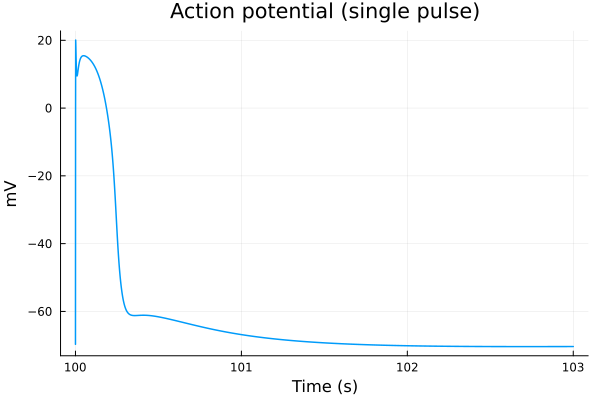

In [4]:
plot(sol, idxs=(sys.t/1000, sys.vm), title="Action potential (single pulse)", ylabel="mV", xlabel="Time (s)", label=false, tspan=(100second, 103second))

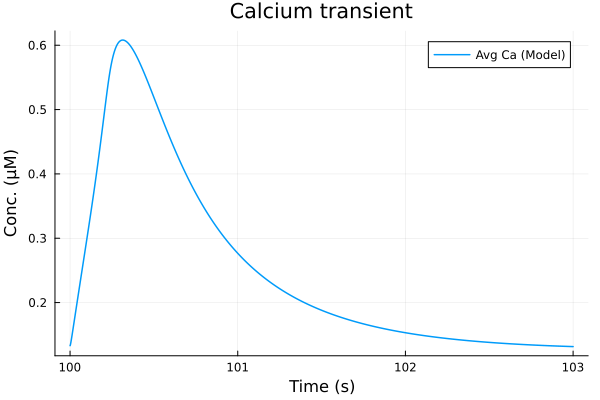

In [5]:
plot(sol, idxs=(sys.t/1000, sys.Cai_mean), tspan=(100second, 103second), title="Calcium transient", ylabel="Conc. (μM)", xlabel="Time (s)", label="Avg Ca (Model)")

# savefig("single-cat.pdf")

## 1Hz

In [6]:
callback = build_stim_callbacks(Istim, stimend; period=1second, starttime=stimstart)
@time sol = solve(prob, alg; callback)

  2.600046 seconds (181.24 k allocations: 45.042 MiB, 1.74% gc time)


retcode: Success
Interpolation: 3rd order Hermite
t: 22357-element Vector{Float64}:
      0.0
      0.00037376965588217846
      0.004111466214703963
      0.03981907054375368
      0.06090491262855715
      0.1655435225566852
      0.2409336011179059
      0.5227875405036884
      1.0858597487365014
      2.388889121726196
      ⋮
 480346.9749024962
 482699.7883395445
 485052.6017765928
 487499.69929415866
 490270.4874344493
 493041.27557473996
 495812.0637150306
 498582.85185532126
 500000.0
u: 22357-element Vector{Vector{Float64}}:
 [0.0026, 830.0, 830.0, 0.00702, 0.966, 0.22156, 0.09243, 0.00188, 0.00977, 0.26081  …  0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, -68.79268, 13838.37602, 150952.75035000002]
 [0.0025999722040421203, 829.9999902796054, 829.9999993331091, 0.007020004989170199, 0.9660000353355825, 0.22156007721482085, 0.09242995488968388, 0.0018799969383422777, 0.009769997724445615, 0.2608099143344817  …  0.12113, 0.12113, 0.12113, 0.12113, 0.12113000000

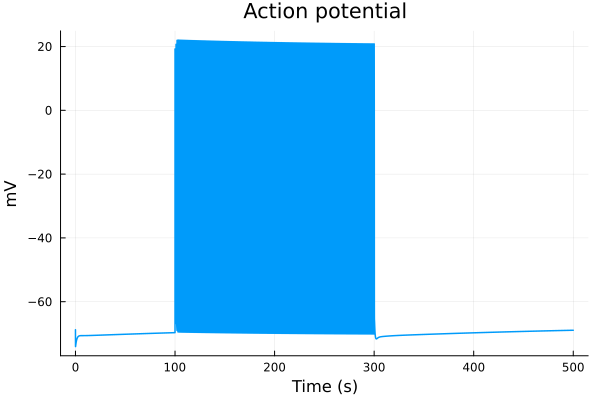

In [7]:
plot(sol, idxs=(sys.t/1000, sys.vm), title="Action potential", ylabel="mV", xlabel="Time (s)", label=false)

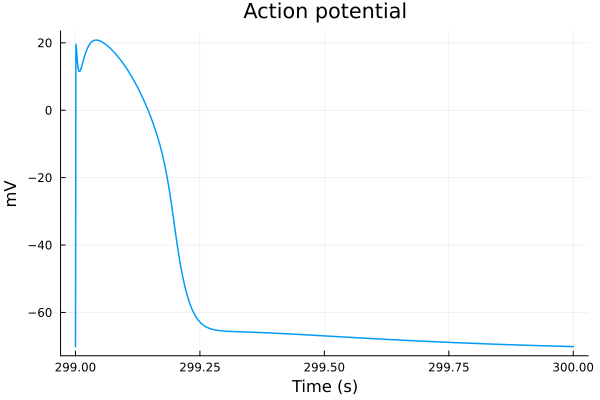

In [8]:
plot(sol, idxs=(sys.t/1000, sys.vm), title="Action potential", tspan=(299second, 300second), ylabel="mV", xlabel="Time (s)", label=false)

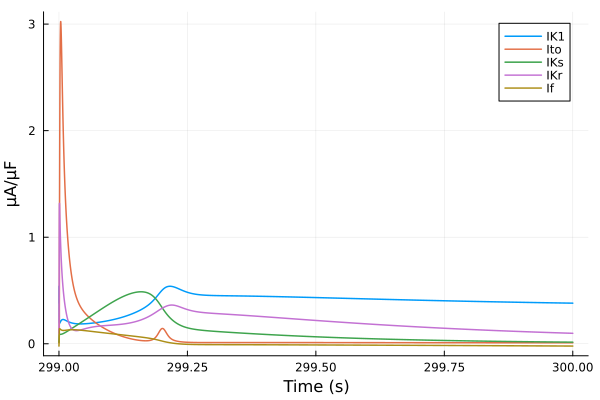

In [9]:
plot(sol, idxs=(sys.t/1000, [sys.IK1, sys.Ito, sys.IKs, sys.IKr, sys.If]), tspan=(299second, 300second), ylabel="μA/μF", xlabel="Time (s)", label=["IK1" "Ito" "IKs" "IKr" "If"])

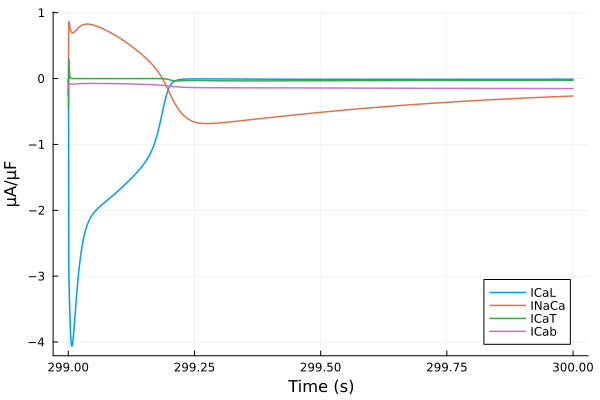

In [10]:
plot(sol, idxs=(sys.t/1000, [sys.ICaL, sys.INaCa, sys.ICaT, sys.ICab]), tspan=(299second, 300second), ylabel="μA/μF", xlabel="Time (s)", label=["ICaL" "INaCa" "ICaT" "ICab"])

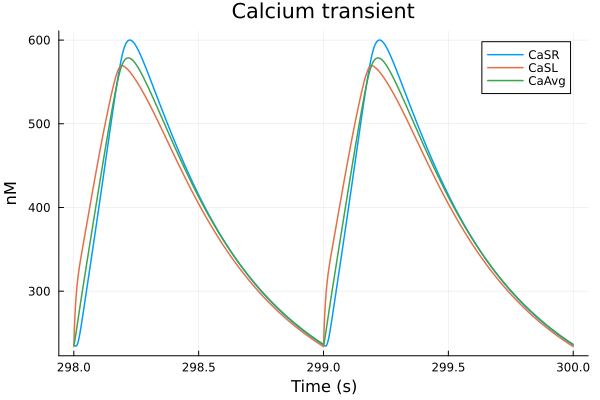

In [11]:
plot(sol, idxs=(sys.t/1000, [sys.Cai_sub_SR * 1000, sys.Cai_sub_SL * 1000, sys.Cai_mean * 1000]), tspan=(298second, 300second), title="Calcium transient", ylabel="nM", xlabel="Time (s)", label=["CaSR" "CaSL" "CaAvg"])

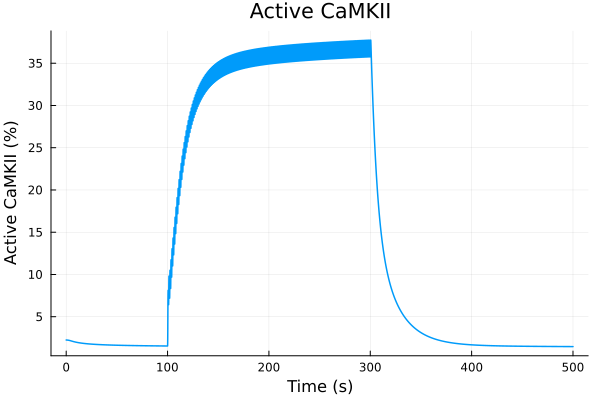

In [12]:
plot(sol, idxs=(sys.t/1000, sys.CaMKAct * 100), title="Active CaMKII", ylabel="Active CaMKII (%)", xlabel="Time (s)", label=false)

### 3D surface plot

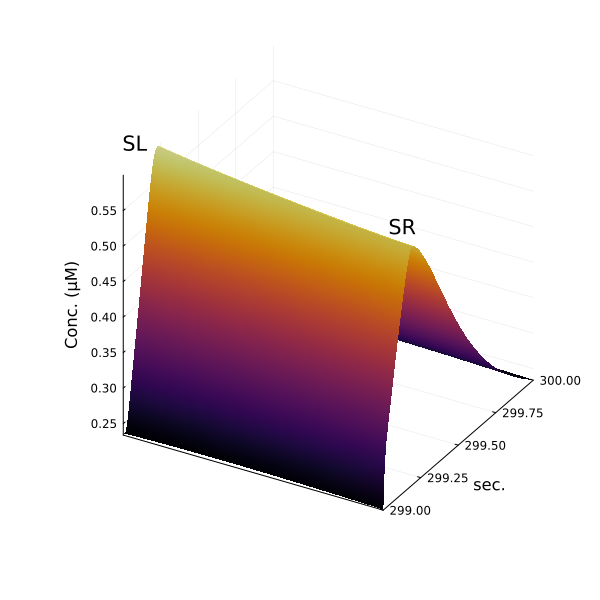

In [13]:
xx = 1:44
yy = range(299second, 300second, length=100)
zz = [sol(t, idxs=sys.Cai[u]) for t in yy, u in xx]

surface(xx, yy./1000, zz, colorbar=:none, yguide="sec.", zguide="Conc. (μM)", xticks=false, size=(600, 600))
annotate!(3, 299, 0.65, "SL")
annotate!(41, 299.25, 0.58, "SR")

# savefig("3d-surface.pdf")

## 2Hz

In [14]:
callback = build_stim_callbacks(Istim, stimend; period=1 / 2 * second, starttime=stimstart)
@time sol2 = solve(prob, alg; callback)

  4.671058 seconds (303.78 k allocations: 76.078 MiB, 1.67% gc time)


retcode: Success
Interpolation: 3rd order Hermite
t: 37424-element Vector{Float64}:
      0.0
      0.00037376965588217846
      0.004111466214703963
      0.03981907054375368
      0.06090491262855715
      0.1655435225566852
      0.2409336011179059
      0.5227875405036884
      1.0858597487365014
      2.388889121726196
      ⋮
 483929.7859758596
 486242.4065716669
 489008.70645342313
 492413.4139810658
 494864.77851831337
 496435.0673654913
 498148.7670705069
 499714.3848786381
 500000.0
u: 37424-element Vector{Vector{Float64}}:
 [0.0026, 830.0, 830.0, 0.00702, 0.966, 0.22156, 0.09243, 0.00188, 0.00977, 0.26081  …  0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, 0.12113, -68.79268, 13838.37602, 150952.75035000002]
 [0.0025999722040421203, 829.9999902796054, 829.9999993331091, 0.007020004989170199, 0.9660000353355825, 0.22156007721482085, 0.09242995488968388, 0.0018799969383422777, 0.009769997724445615, 0.2608099143344817  …  0.12113, 0.12113, 0.12113, 0.12113, 0.121130000000

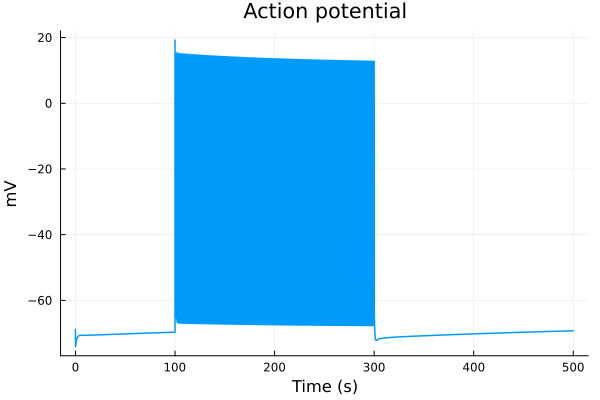

In [15]:
plot(sol2, idxs=(sys.t/1000, sys.vm), title="Action potential", ylabel="mV", xlabel="Time (s)", label=false)

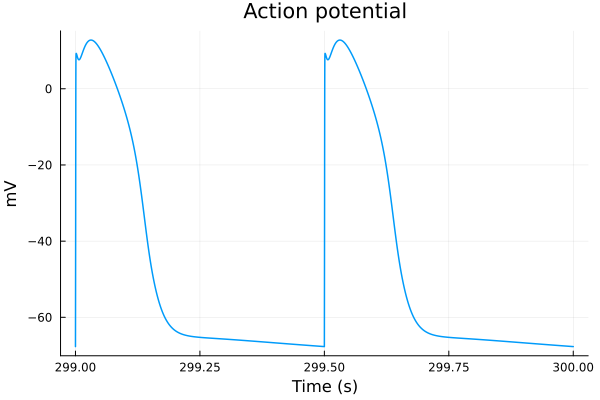

In [16]:
plot(sol2, idxs=(sys.t/1000, sys.vm), title="Action potential", tspan=(299second, 300second), ylabel="mV", xlabel="Time (s)", label=false)

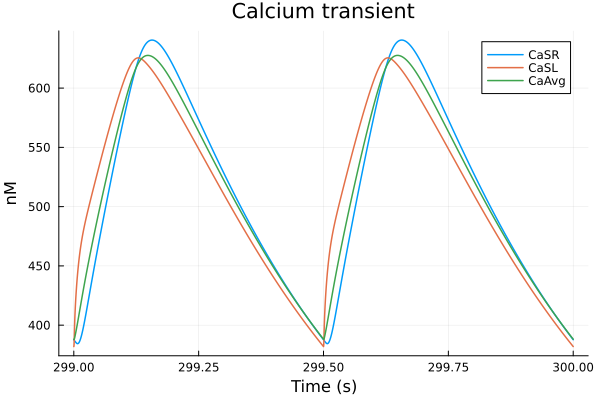

In [17]:
plot(sol2, idxs=(sys.t/1000, [sys.Cai_sub_SR * 1000, sys.Cai_sub_SL * 1000, sys.Cai_mean * 1000]), tspan=(299second, 300second), title="Calcium transient", ylabel="nM", xlabel="Time (s)", label=["CaSR" "CaSL" "CaAvg"])

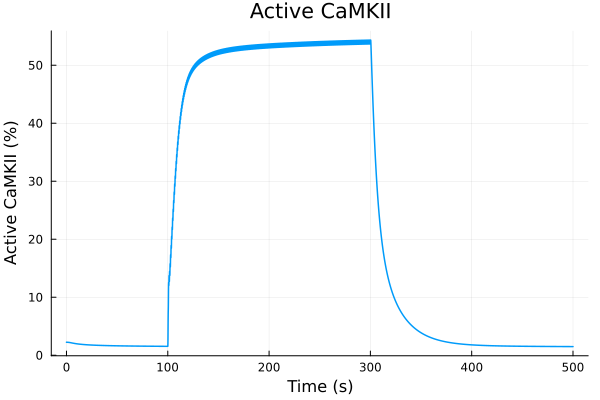

In [18]:
plot(sol2, idxs=(sys.t/1000, sys.CaMKAct * 100), title="Active CaMKII", ylabel="Active CaMKII (%)", xlabel="Time (s)", label=false)

## Comparing 1 and 2 Hz pacing

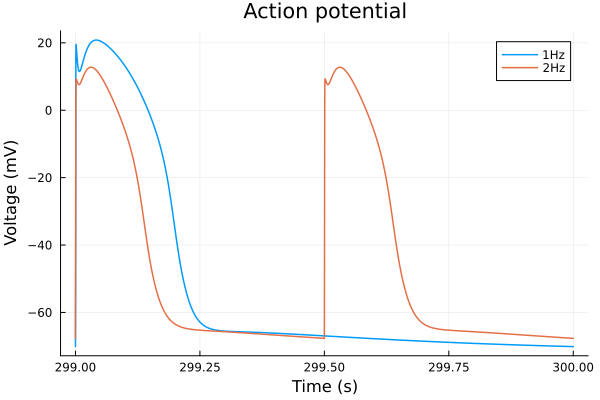

In [19]:
plot(sol, idxs=(sys.t/1000, sys.vm), title="Action potential", lab="1Hz",  tspan=(299second, 300second))
plot!(sol2, idxs=(sys.t/1000, sys.vm), lab="2Hz", tspan=(299second, 300second), xlabel="Time (s)", ylabel="Voltage (mV)")

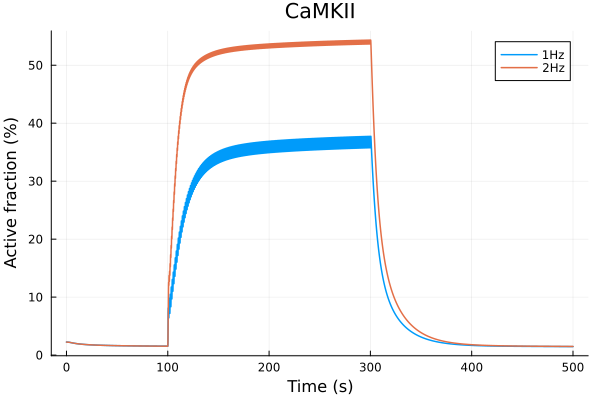

In [20]:
idxs=(sys.t/1000, sys.CaMKAct * 100)
plot(sol, idxs=idxs, title="CaMKII", lab="1Hz")
plot!(sol2, idxs=idxs, lab="2Hz", xlabel="Time (s)", ylabel="Active fraction (%)")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*